In [1]:
from lib.tgcf_dtc import TGCF_dtc
from lib.tgcf_imm import TGCF_imm
from lib.tgcf_rf import TGCF_rf
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer, load_diabetes

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

# Create dataset and perform Clustering

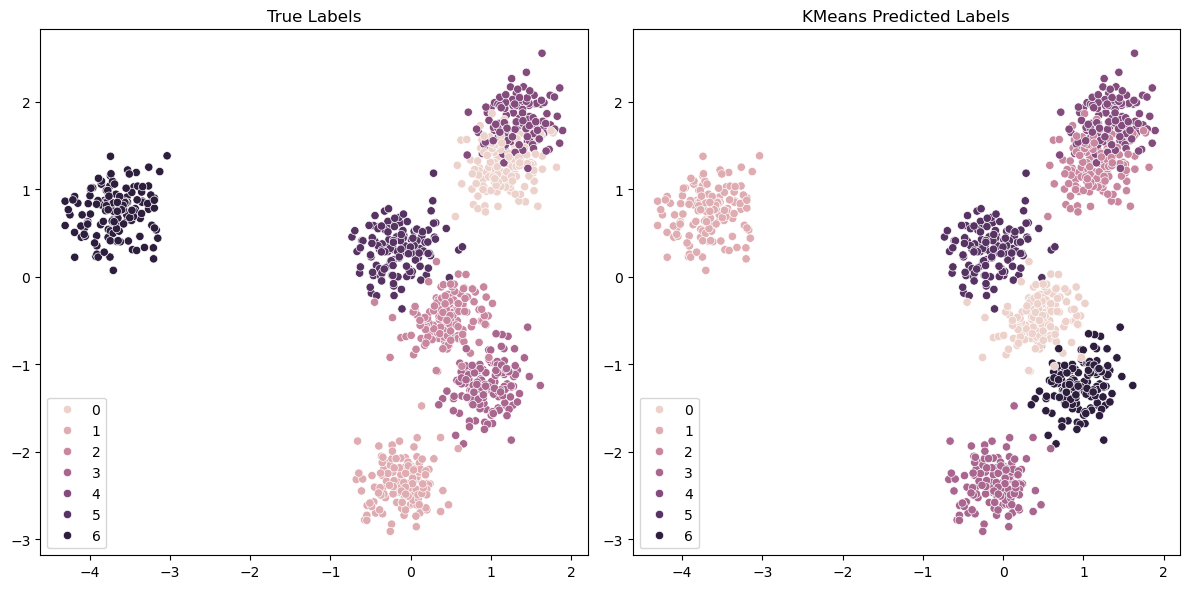

[[ 1.76445541  0.3288613  -1.0893157   1.50343889  0.97741605 -0.5279037
  -1.19631207 -1.55625826]
 [ 0.0305089   0.71409028  0.59762073 -0.49281079 -1.94834205 -0.53241676
  -1.48038037  1.46815793]
 [ 0.63887202  1.34421439  0.60207756 -0.40285572 -1.23971173 -0.98071194
  -1.48521765  1.13245616]
 [-0.57728743 -0.56337404 -0.13622051 -1.76992268  0.37922913 -0.2504756
  -0.09365098 -0.76027926]
 [ 0.36811618  0.51594769 -0.79127996 -1.37575717  0.1353421  -0.94209538
   1.11474443 -1.29217901]
 [-1.67563423  1.29221234  1.61711587  0.18605879 -0.85563661 -0.65586235
   1.48649727 -0.32017006]
 [ 0.39732094  0.46900954 -0.90773861 -0.92772584  0.60329771 -0.72317495
   0.65069012 -1.51125611]
 [-0.35941899  0.67643491  0.82574473  0.32158602 -0.95289795 -0.39297212
  -1.23448235  1.50645118]
 [-0.78515316 -0.57729671 -1.23638102  0.52985894 -1.15042982  0.7418008
  -0.32892731 -0.19727561]
 [ 0.76716198 -1.13494263  1.60909148  0.34956549  1.5337587   2.16721306
   0.84118123  1.332

In [2]:
dims = 8
n = 1000
# seed = 5
# k = 5
seed = 42
k = 7
min_impurity_decrease = 0.001 # minimum impurity decrease to split for DTC
threshold_change = 0.01 # amount that will be changed to either side of the threshold
robustness_factor = 0.3 # DTC robustness post processing factor

X, _y = make_blobs(centers=k, cluster_std=1.4, n_features=dims, n_samples=n, random_state=seed)
# data = load_iris()
# X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k, random_state=seed)
model.fit(X)

centers = model.cluster_centers_
y = model.predict(X)
dims = X.shape[1]
n = X.shape[0]
k = len(centers)

# plot the clusters
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with true labels
if dims > 2:
    sns.scatterplot(ax=axes[0], x=embed_X[:, 0], y=embed_X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")
else:
    sns.scatterplot(ax=axes[0], x=X[:, 0], y=X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")

# Plot with KMeans labels
if dims > 2:
    sns.scatterplot(ax=axes[1], x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")
else:
    sns.scatterplot(ax=axes[1], x=X[:, 0], y=X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")

plt.tight_layout()
plt.show()

print(X[:10])

# Choose instance and target

In [3]:
instance_index = np.where(y == 2)[0][0] # Instance class index
instance = X[instance_index]
target_class = 0
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 2, point: [ 0.0305089   0.71409028  0.59762073 -0.49281079 -1.94834205 -0.53241676
 -1.48038037  1.46815793]
Target center class: 0, point: [-0.26897149 -0.51508789 -0.10861383 -1.71851772  0.30126112 -0.54112587
 -0.44044299 -0.44919231]



# Find cfs using Decision Tree Classifier

DTC accuracy: 1.0


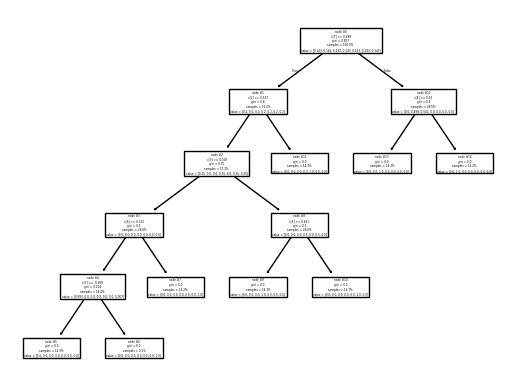

Instance: [ 0.0305089   0.71409028  0.59762073 -0.49281079 -1.94834205 -0.53241676
 -1.48038037  1.46815793]
Instance prediction : [2]

CFS: [[ 0.0305089   0.71409029  0.52678257 -0.87892932 -1.94834208 -0.53241676
  -1.48038042  0.67927116]]
CF predictions:  [2]
CFs prime: [[ 0.0305089   0.71409029  0.33616365 -1.13080584 -1.94834208 -0.53241676
  -1.48038042  0.34073212]]
CFs prime predictions:  [2]


In [4]:
tgcf_dtc = TGCF_dtc(model, centers, X, y)
tgcf_dtc.fit(improve_tree_fidelity=False, min_impurity_decrease=min_impurity_decrease)

cfs = tgcf_dtc.find_counterfactuals(instance, target_class, False, threshold_change=threshold_change)
cfs_prime = tgcf_dtc.plausibility_fix(cfs, instance, target_class, robustness_factor)

tgcf_dtc.print_tree()
print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
print("")
print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
print(f'CFs prime: {cfs_prime}')
print(f'CFs prime predictions: ', model.predict(cfs_prime))

# Find cfs using Iterative Mistake Minimization(IMM)

In [5]:

tgcf_imm = TGCF_imm(model, centers, X, y)
tgcf_imm.fit()
cf = tgcf_imm.find_counterfactuals(instance, target_class, threshold_change=threshold_change)
cf_prime = tgcf_imm.plausibility_fix(cf, instance, target_class, robustness_factor)

print("Instance: ", instance)
print("Original class: ", model.predict([instance]))
print("Counterfactual: ", cf)
print("Counterfactual class: ", model.predict(cf))
print("")
print("Counterfactual prime: ", cf_prime)
print("Counterfactual prime class: ", model.predict(cf_prime))
tgcf_imm.print_tree()

Instance:  [ 0.0305089   0.71409028  0.59762073 -0.49281079 -1.94834205 -0.53241676
 -1.48038037  1.46815793]
Original class:  [2]
Counterfactual:  [[ 0.0305089   0.71409028  0.59762073 -0.49281079 -1.94834205 -0.53241676
  -1.48038037  0.14067876]]
Counterfactual class:  [2]

Counterfactual prime:  [[ 0.0305089   0.71409028  0.59762073 -0.49281079 -1.94834205 -0.53241676
  -1.48038037 -0.03628256]]
Counterfactual prime class:  [2]
├── L0: f5 < 0.5070188943669311
│   ├── L1: f6 < -0.06269885651037022
│   │   ├── L2: f7 < 0.1506787584761724
│   │   │   ├── L3: f2 < -0.6494166053828754
│   │   │   │   ├── L4, C: 3
│   │   │   │   └── L4, C: 0
│   │   │   └── L3, C: 2
│   │   └── L2: f0 < -0.48455798232364194
│   │       ├── L3, C: 4
│   │       └── L3, C: 6
│   └── L1: f0 < -0.06320226498430415
│       ├── L2, C: 5
│       └── L2, C: 1



In [6]:
tgcf_dtc.plot_tree()
tgcf_imm.plot_tree()

ValueError: Only 2D data can be plotted.

# Threshold Tree DTC normal vs fidelity improvement

DTC accuracy: 0.996
Instance prediction : [2]
CF predictions:  [2 6 0 0 0]
CFs prime predictions:  [0 0 0 0 0]


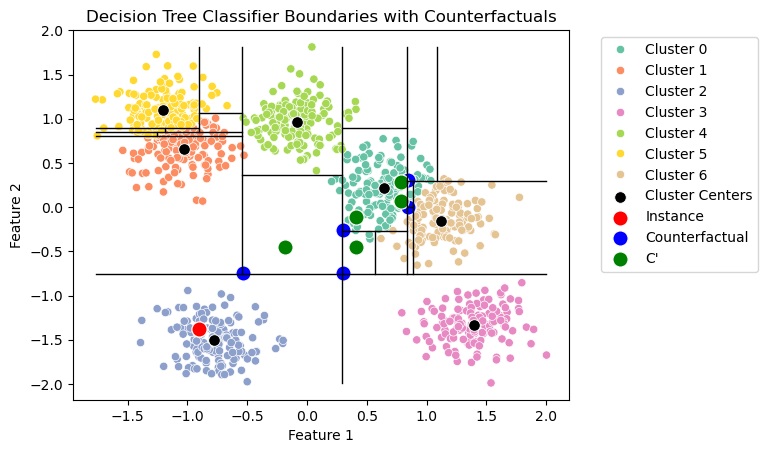

DTC accuracy: 0.996
Instance prediction : [2]
CF predictions:  [2 6 0 0 0]
CFs prime predictions:  [0 0 0 0 0]


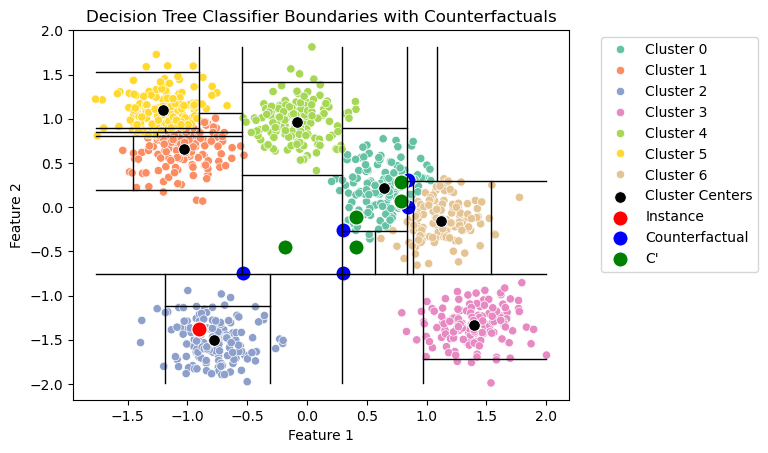

In [ ]:
# Normal method
tgcf_dtc = TGCF_dtc(model, centers, X, y)
tgcf_dtc.fit(improve_tree_fidelity=False, min_impurity_decrease=min_impurity_decrease)

cfs = tgcf_dtc.find_counterfactuals(instance, target_class, False, threshold_change=threshold_change)
cfs_prime = tgcf_dtc.plausibility_fix(cfs, instance, target_class, robustness_factor)

# print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
# print("")
# print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
# print(f'CFs prime: {cfs_prime}')
print(f'CFs prime predictions: ', model.predict(cfs_prime))
tgcf_dtc.plot_tree()



# Fidelity improvement
tgcf_dtc = TGCF_dtc(model, centers, X, y)
tgcf_dtc.fit(improve_tree_fidelity=True, min_impurity_decrease=min_impurity_decrease)

cfs = tgcf_dtc.find_counterfactuals(instance, target_class, True, threshold_change=threshold_change)
cfs_prime = tgcf_dtc.plausibility_fix(cfs, instance, target_class, robustness_factor)

# print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
# print("")
# print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
# print(f'CFs prime: {cfs_prime}')
print(f'CFs prime predictions: ', model.predict(cfs_prime))
tgcf_dtc.plot_tree()

# Find cfs using Random Forest Classifier

Random Forest accuracy: 0.994


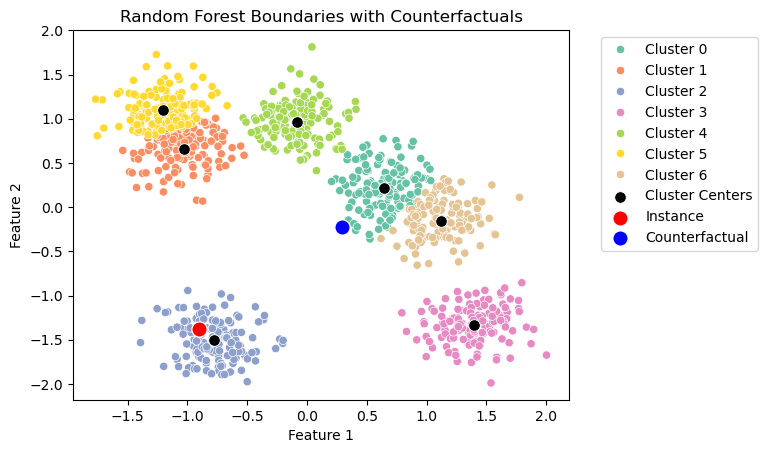

In [ ]:
tgcf_rf = TGCF_rf(model, centers, X, y)
tgcf_rf.fit()
cf = tgcf_rf.find_counterfactuals(instance, target_class, threshold_change=threshold_change, ratio_of_trees=0.4)
tgcf_rf.plot_tree()